In [1]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt

In [2]:
def filter_by_title_w_keyword(df, keywords):
    temp = []
    for keyword in keywords:
        temp.append(df[df.title.str.contains(keyword)])
    filtered_df = pd.concat(temp, axis=0).drop_duplicates()
    return filtered_df

In [3]:
def filter_by_content_w_keyword(df, keywords):
    temp = []
    for keyword in keywords:
        temp.append(df[df.content.str.contains(keyword).astype(bool).fillna(False)])        
    filtered_df = pd.concat(temp, axis=0).drop_duplicates()
    return filtered_df

In [4]:
def date_formatting_clien(datetime):
    return datetime.split()[0].replace('-', '.').strip()

def date_formatting_fm(datetime):
    return datetime.split()[0]

def date_formatting_bobaedream(datetime):
    return str(20)+datetime.replace(' ', '').strip()

def remove_comma(val):
    return val.replace(',','')

# Preprocessing

## Read Posts

In [5]:
# read csv
clien_posts_df = pd.read_csv('data/clien-르노-posts.csv')  
# fm_posts_df = pd.read_csv('data/fm-르노-posts.csv')  
bobaedream_posts_df = pd.read_csv('data/bobaedream-르노-posts.csv') 

# datetime formatting
clien_posts_df.created_at = clien_posts_df.created_at.apply(date_formatting_clien)
# fm_posts_df.created_at = fm_posts_df.created_at.apply(date_formatting_fm)
bobaedream_posts_df.created_at = bobaedream_posts_df.created_at.apply(date_formatting_bobaedream) 

# posts_df = pd.concat([clien_posts_df, fm_posts_df, bobaedream_posts_df], axis=0)
# assert len(posts_df)==(len(clien_posts_df)+len(fm_posts_df)+len(bobaedream_posts_df))

posts_df = pd.concat([clien_posts_df, bobaedream_posts_df], axis=0)
assert len(posts_df)==(len(clien_posts_df)+len(bobaedream_posts_df))

In [8]:
print(f"posts data shape: {posts_df.shape}")

posts data shape: (657, 9)


### 키워드를 이용하여 '르노 사건' 관련 데이터 추출

In [9]:
keywords = ['손가락', '남혐', '여혐']
title_filtered_posts_df = filter_by_title_w_keyword(posts_df, keywords)
title_filtered_posts_df.shape

(40, 9)

In [10]:
keywords = ['손가락', '남혐', '여혐']
content_filtered_posts_df = filter_by_content_w_keyword(posts_df, keywords)
content_filtered_posts_df.shape

(75, 9)

In [11]:
filtered_posts_df = pd.concat([title_filtered_posts_df, content_filtered_posts_df], axis=0) \
    .drop_duplicates() \
    .sort_values(by=['created_at'], axis=0)

In [12]:
filtered_posts_df.dtypes

id              int64
created_at     object
updated_at    float64
title          object
content        object
likes          object
url            object
author         object
views          object
dtype: object

In [13]:
filtered_posts_df.created_at= filtered_posts_df.created_at.astype('datetime64[s]')
filtered_posts_df.updated_at= filtered_posts_df.created_at.astype('datetime64[s]')
filtered_posts_df.title= filtered_posts_df.title.astype('str')
filtered_posts_df.content= filtered_posts_df.content.astype('str')
filtered_posts_df.likes= filtered_posts_df.likes.astype('str').map(remove_comma).astype('int64')
filtered_posts_df.url= filtered_posts_df.url.astype('str')
filtered_posts_df.author= filtered_posts_df.author.astype('str')
filtered_posts_df.views= filtered_posts_df.views.astype('str').map(remove_comma).astype('int64')

In [14]:
filtered_posts_df.columns

Index(['id', 'created_at', 'updated_at', 'title', 'content', 'likes', 'url',
       'author', 'views'],
      dtype='object')

## Read Comments

In [15]:
# read csv
clien_comments_df = pd.read_csv('data/clien-르노-comments.csv')  
# fm_posts_df = pd.read_csv('data/fm-르노-posts.csv')  
bobaedream_comments_df = pd.read_csv('data/bobaedream-르노-comments.csv') 

In [16]:
# drop date
bobaedream_comments_df = bobaedream_comments_df.drop(labels='date', axis=1)
comments_df = pd.concat([clien_comments_df, bobaedream_comments_df], axis=0)

assert len(comments_df) == (len(clien_comments_df) + len(bobaedream_comments_df))
comments_df.shape

(11024, 4)

In [18]:
print(comments_df.dtypes)
print(comments_df.columns)

id         float64
post_id      int64
content     object
author      object
dtype: object
Index(['id', 'post_id', 'content', 'author'], dtype='object')


In [21]:
df = pd.merge(left = filtered_posts_df , right = comments_df, how = "inner", left_on=['id'], right_on = ['post_id'])
df.rename(columns = {'content_x':'post_content', 'author_x':'post_author', \
    'content_y':'cmt_content', 'author_y':'cmt_author'}, inplace = True)
df = df.drop(labels='id_x', axis=1)
df = df.drop(labels='id_y', axis=1)

In [22]:
df.columns

Index(['created_at', 'updated_at', 'title', 'post_content', 'likes', 'url',
       'post_author', 'views', 'post_id', 'cmt_content', 'cmt_author'],
      dtype='object')

# EDA

## Number of Posts per day

Text(0.5, 1.0, 'Number of Posts per day')

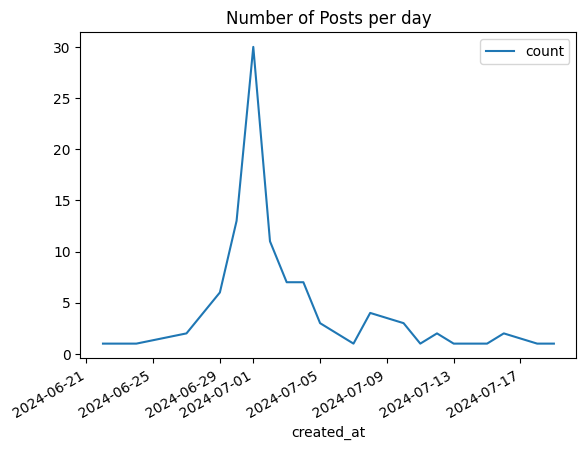

In [23]:
per_day_view = filtered_posts_df.loc[:, ["created_at", "views"]]
per_day_view = per_day_view.groupby(per_day_view.created_at)['views'].count().reset_index(name='count')
per_day_view.plot(0, 1)
plt.title("Number of Posts per day")    

## Number of Posts per day (공감 수 n 이상)

Text(0.5, 1.0, 'Number of Posts per day (likes > 5)')

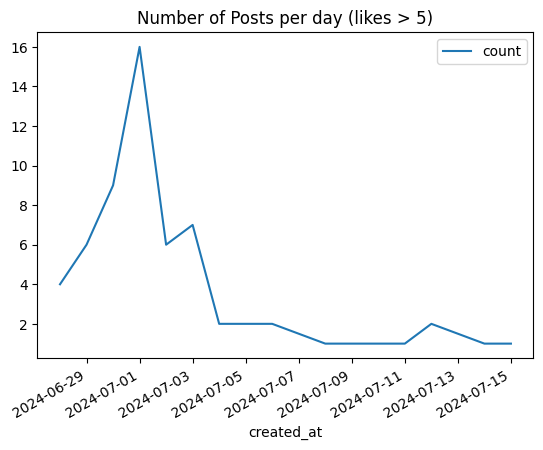

In [25]:
n = 5
per_day_view = filtered_posts_df.loc[:, ["created_at", "views"]].loc[filtered_posts_df.likes > n]
per_day_view = per_day_view.groupby(per_day_view.created_at)['views'].count().reset_index(name='count')
per_day_view.plot(0, 1)
plt.title(f"Number of Posts per day (likes > {n})")

Text(0.5, 1.0, 'Number of Posts per day (likes > 10)')

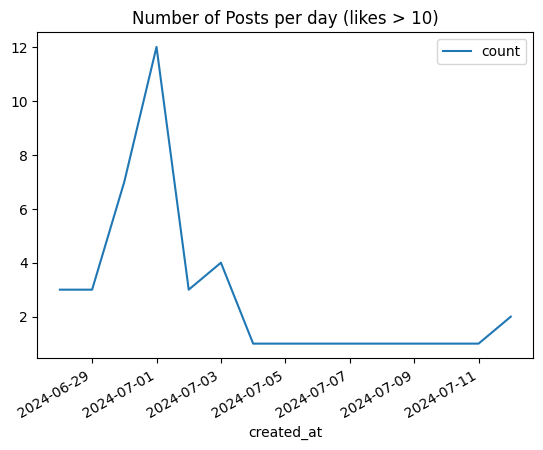

In [26]:
n = 10
per_day_view = filtered_posts_df.loc[:, ["created_at", "views"]].loc[filtered_posts_df.likes > n]
per_day_view = per_day_view.groupby(per_day_view.created_at)['views'].count().reset_index(name='count')
per_day_view.plot(0, 1)
plt.title(f"Number of Posts per day (likes > {n})")    

Text(0.5, 1.0, 'Number of Posts per day (likes > 15)')

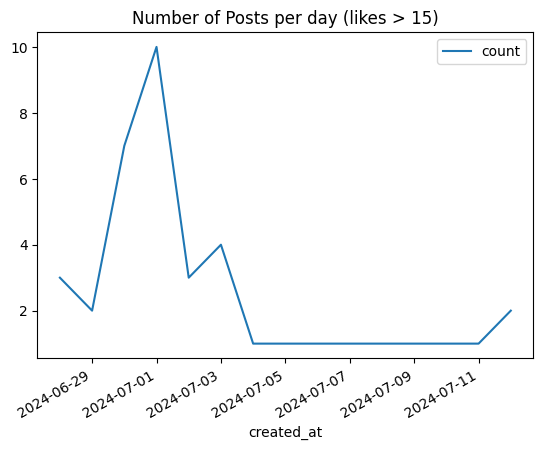

In [27]:
n = 15
per_day_view = filtered_posts_df.loc[:, ["created_at", "views"]].loc[filtered_posts_df.likes > n]
per_day_view = per_day_view.groupby(per_day_view.created_at)['views'].count().reset_index(name='count')
per_day_view.plot(0, 1)
plt.title(f"Number of Posts per day (likes > {n})")    

## Number of View per day

Text(0.5, 1.0, 'Number of Views per day')

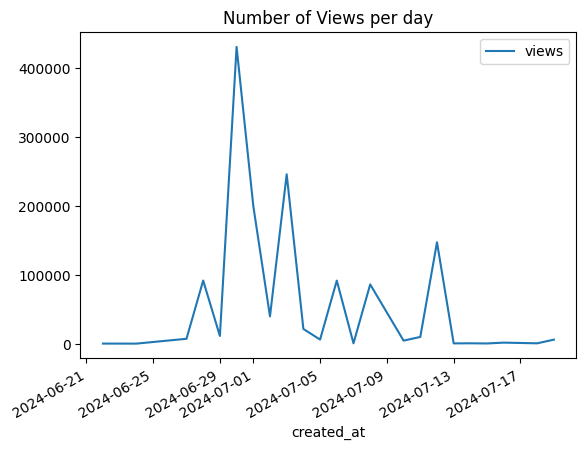

In [28]:
per_day_view = filtered_posts_df.loc[:, ["created_at", "views"]]
per_day_view = per_day_view.groupby(per_day_view.created_at).sum()
per_day_view.plot()
plt.title("Number of Views per day")

## Number of comments per day (게시물 작성 날짜 기준)

Text(0.5, 1.0, 'Number of comments per day (post created at)')

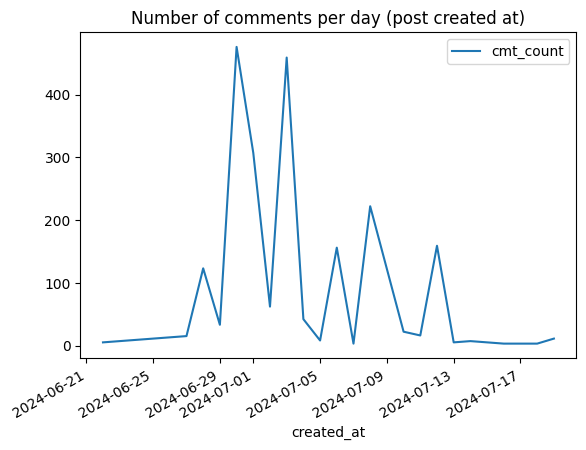

In [31]:
df_per_posts_cmt = df.loc[:, ["created_at", "post_id", "cmt_content"]].groupby(['created_at', 'post_id']).count()
df_per_posts_cmt = df_per_posts_cmt.groupby(['created_at'])['cmt_content'].sum().reset_index(name='cmt_count')
df_per_posts_cmt.plot(0, 1)
plt.title("Number of comments per day (post created at)")

# Number of comments per day (댓글 작성 날짜 기준)

# 생각해보기
- 날짜 별 추이는 너무 rough하게 나온다. 더 작은 interval로 추세를 확인해 볼 필요가 있음
- tabular data에 시계열적인 정보를 넣어줘야 하는데, 어떤 정보를 넣을 수 있을까?
- 시간 별 조회수 합? 
- 댓글 수 
- 과거의 글에 댓글이 달리면?
- positive/negative


In [30]:
events = []
events.append(posts_df[posts_df.title.str.contains('손가락')])
events.append(posts_df[posts_df.title.str.contains('남혐')])
events.append(posts_df[posts_df.title.str.contains('혐오')])
filtered_posts_df = pd.concat([clien_comments_df, fm_comments_df, bobaedream_comments_df], axis=0).drop_duplicates()
filtered_posts_df.columns

Index(['id', 'post_id', 'content', 'author', 'time', 'date'], dtype='object')

In [ ]:
filtered_posts_df = filtered_posts_df.sort_values(by=[filtered_posts_df.created_at])
print(f"filtered_posts_df: {filtered_posts_df.shape}")

,id,created_at,updated_at,title,content,likes,url,author,views
0,18768726,2024-07-20 21:23:43,NaN,엔진오일 저점도 트렌드 이유가 뭔가요?,BMW 20d B47 디젤 기준 예로 들면이전에는 LL-04 ACEA C3 기반 H...,0,https://www.clien.net/service/board/cm_car/187...,펀드라이빙,5431
1,18768580,2024-07-20 16:52:46,NaN,경남 진주 그랑콜레오스 내일들어온다네요,내일 구경하러 가야겟습니당쏘렌토 싼타페 콜레오스 카니발 팰리세이드 트래버스까지 패밀...,0,https://www.clien.net/service/board/park/18768...,이게무슨개소리야,2842
2,18768265,2024-07-20 01:15:19,NaN,"(그랑콜레오스) 기본기도, 신뢰도도 의문. 거기다 성의도 없네요.",차키는 그냥 뚜껑만 바꿔치기... 정말 성의라고는 없네요.르삼때부터 개인적으로 좋아...,1,https://www.clien.net/service/board/cm_car/187...,Rize,13186
3,18768082,2024-07-19 18:48:31,NaN,쏘렌토 하이브리드 잘 팔리는 이유 알겠어요.,싼타페급 suv 사려고 보니 쏘렌토가 잘 팔리는 이유알겠어요.싼타페는 디자인 호불호...,0,https://www.clien.net/service/board/park/18768...,매복,8514
4,18767953,2024-07-19 15:43:53,NaN,그랑 콜레오스 전시차 들어왔다고 문자와서 구경갔다왔습니다.,부산모터쇼에는 사람이 많아서 제대로 못봤는데 생각보다 괜찮네요가격도 생각보다 저렴해...,2,https://www.clien.net/service/board/cm_car/187...,야광멧돼지,6011


In [ ]:
clien_posts_df.head()